<a href="https://colab.research.google.com/github/Eunju-Choe/Eunju-Choe/blob/main/5_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html

In [1]:
!pip install finance-datareader

     |████████████████████████████████| 48 kB 2.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import confusion_matrix, accuracy_score

print('import')

import


In [3]:
def rmsle(y_pred, y_past):
    n = len(y_pred)
    RMSLE = np.sqrt(sum((y_pred - y_past) ** 2)/(n-1))
    return float(RMSLE)


def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x) # np.array를 dataset으로 변환
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x : x.batch(window_size))
    
    # y값 window dataset 구성
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    
    # dataset 구성 완료
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    if shuffle:
        ds = ds.shuffle(1000)
    
    # batch 생성 : prefetch (미리 데이터를 fetch하는 개수 -> 병렬처리로 학습속도 개선)
    return ds.batch(batch_size).prefetch(1)


def print_score(y_test, pred):
    print(f"RMSE : {mse(y_test[WINDOW_SIZE:], pred) ** 0.5:.3f}")
    print(f"MAE : {mae(y_test[WINDOW_SIZE:], pred):.3f}")
    print(f"MAPE : {mape(y_test[WINDOW_SIZE:], pred):.3f}")
    print(f"RMSLE : {rmsle(pred, y_test[WINDOW_SIZE-1:-1]):.3f}")
    
    
def plot_result(y_test, pred):
    plt.figure(figsize=(12,9))
    plt.plot(np.asarray(y_test[WINDOW_SIZE:]), label='actual')
    plt.plot(pred, label='prediction')
    num_ind = [0, 20, 38, 60, 82, 101, 123, 145, 166, 185, 204, 226, 247]
    num_ind = np.array(num_ind) - WINDOW_SIZE
    ind = ['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
           '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01']
    plt.xticks(num_ind, ind)
    plt.legend()
    plt.title(f'Window Size = {WINDOW_SIZE}, epoch = {EPOCH}', fontsize=20)
    plt.show()
    
print('function')

function


In [4]:
# 데이터 불러오기
df = fdr.DataReader('KS11', start='2017', end='2022')
df = df.drop(['Change', 'Volume'], axis=1)
df.head()

,Close,Open,High,Low
Date,,,,
2017-01-02,2026.16,2022.23,2031.79,2015.68
2017-01-03,2043.97,2034.31,2044.07,2028.47
2017-01-04,2045.64,2046.29,2046.29,2040.61
2017-01-05,2041.95,2045.52,2046.50,2039.49
2017-01-06,2049.12,2048.11,2051.84,2045.66


In [5]:
# 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
df_scaled.head()

,Close,Open,High,Low
Date,,,,
2017-01-02,0.307712,0.299168,0.286240,0.310478
2017-01-03,0.317352,0.305766,0.293065,0.317369
2017-01-04,0.318256,0.312309,0.294298,0.323910
2017-01-05,0.316259,0.311888,0.294415,0.323306
2017-01-06,0.320139,0.313302,0.297383,0.326631


In [6]:
# train/test 분리
X = df_scaled.copy()
y = df_scaled[['Close']]

X_train = X.loc[:'2020-12-31'].values
X_test = X.loc['2021-01-01':].values
y_train = y.loc[:'2020-12-31'].values
y_test = y.loc['2021-01-01':].values

In [7]:
# INPUT 형태로 정제
WINDOW_SIZE = 14
BATCH_SIZE = 32

train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, False) # 원래 True임
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'데이터셋(X) 구성 (batch_size, window_size, feature 개수) : {data[0].shape}')
    print(f'데이터셋(y) 구성 (batch_size, window_size, feature 개수) : {data[1].shape}')

데이터셋(X) 구성 (batch_size, window_size, feature 개수) : (32, 14, 4)
데이터셋(y) 구성 (batch_size, window_size, feature 개수) : (32, 1)


In [8]:
model = Sequential()
model.add(LSTM(units=32,
               input_shape=(WINDOW_SIZE, 4),
               activation='relu'))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 학습 과정 설정
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)

In [10]:
EPOCH = 1000
history = model.fit(train_data, validation_data=(test_data), epochs=EPOCH, callbacks=[checkpoint])

Epoch 1/1000
     31/Unknown - 2s 16ms/step - loss: 0.1092 - mse: 0.1092
Epoch 1: val_loss improved from inf to 0.03918, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 3s 60ms/step - loss: 0.1092 - mse: 0.1092 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 2/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 2: val_loss improved from 0.03918 to 0.00125, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 1s 26ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012
Epoch 3: val_loss improved from 0.00125 to 0.00120, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 1s 18ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/1000
31/31 [==============================] - ETA: 0s - loss: 9.3020e-04 - mse: 9.3020e-04
Epoch 4: val_loss di

RMSE : 0.018
MAE : 0.015
MAPE : 0.016
RMSLE : 0.010


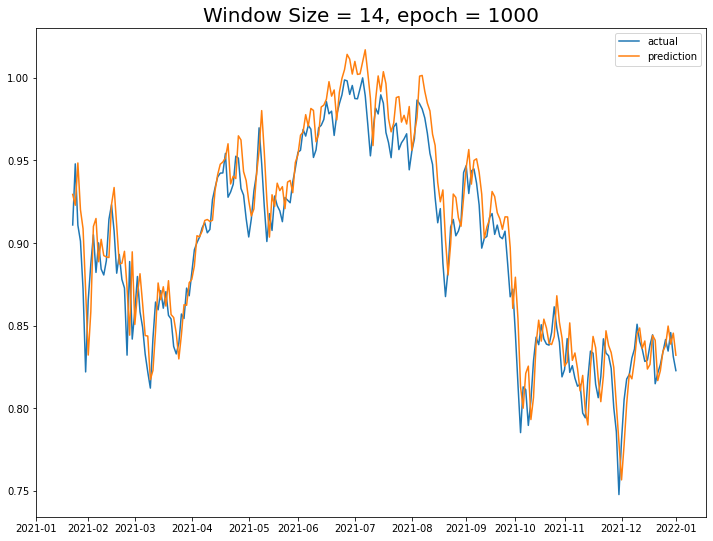

In [11]:
# 저장한 ModelCheckpoint 로드
model.load_weights(filename)
# 예측
pred = model.predict(test_data)
# 성과 지표 출력
print_score(y_test, pred)
# 그래프 출력
plot_result(y_test, pred)

In [12]:
temp = pd.DataFrame(y_test[WINDOW_SIZE:], columns=['actual'])
temp['pred'] = pred
temp['actual_ud'] = temp['actual'].diff().apply(lambda x : 1 if x > 0 else 0)
temp['pred_ud'] = temp['pred'].diff().apply(lambda x : 1 if x > 0 else 0)

print(confusion_matrix(temp['actual_ud'], temp['pred_ud']))
print(f"accuracy : {accuracy_score(temp['actual_ud'], temp['pred_ud']):.3f}")

[[62 53]
 [53 66]]
accuracy : 0.547


# Gaussian Filter

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [14]:
# 데이터 불러오기
df = fdr.DataReader('KS11', start='2017', end='2022')
df = df.drop(['Change', 'Volume'], axis=1)
df.head()

,Close,Open,High,Low
Date,,,,
2017-01-02,2026.16,2022.23,2031.79,2015.68
2017-01-03,2043.97,2034.31,2044.07,2028.47
2017-01-04,2045.64,2046.29,2046.29,2040.61
2017-01-05,2041.95,2045.52,2046.50,2039.49
2017-01-06,2049.12,2048.11,2051.84,2045.66


In [15]:
# gaussian_filter1d(input, sigma)
# sigma : standard deviation for Gaussian kernel

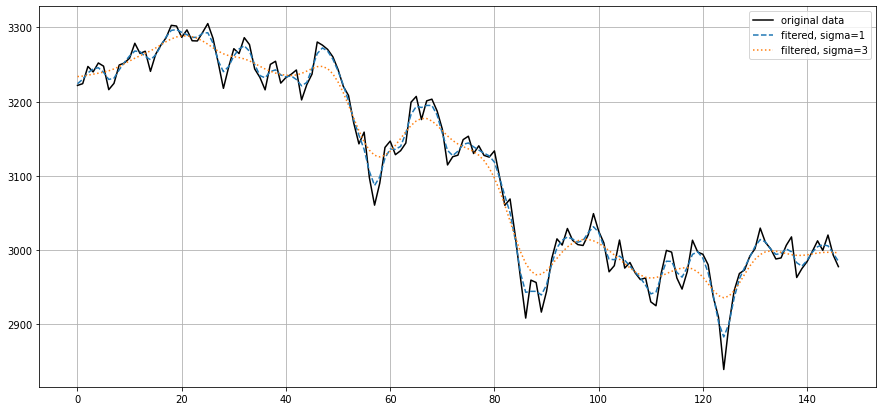

In [16]:
temp = df.loc['2021-06-01':]

y1 = gaussian_filter1d(temp['Close'], 1)
y3 = gaussian_filter1d(temp['Close'], 3)

plt.figure(figsize=(15,7))
plt.plot(temp['Close'].values, 'k', label='original data')
plt.plot(y1, '--', label='fitered, sigma=1')
plt.plot(y3, ':', label='filtered, sigma=3')
plt.legend()
plt.grid()
plt.show()

In [17]:
for col in df.columns:
    df[f'{col}_filt'] = gaussian_filter1d(df[col], sigma=2)
    
df.head()

,Close,Open,High,Low,Close_filt,Open_filt,High_filt,Low_filt
Date,,,,,,,,
2017-01-02,2026.16,2022.23,2031.79,2015.68,2037.665632,2033.762038,2040.499947,2027.787611
2017-01-03,2043.97,2034.31,2044.07,2028.47,2039.334183,2036.182412,2042.083041,2030.373379
2017-01-04,2045.64,2046.29,2046.29,2040.61,2042.002506,2039.939053,2044.717868,2034.428190
2017-01-05,2041.95,2045.52,2046.50,2039.49,2045.097078,2043.741148,2047.909824,2038.611570
2017-01-06,2049.12,2048.11,2051.84,2045.66,2048.725607,2047.018834,2051.700056,2042.301691


In [18]:
# 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
df_scaled.head()

,Close,Open,High,Low,Close_filt,Open_filt,High_filt,Low_filt
Date,,,,,,,,
2017-01-02,0.307712,0.299168,0.286240,0.310478,0.272410,0.266597,0.248747,0.287734
2017-01-03,0.317352,0.305766,0.293065,0.317369,0.273378,0.268005,0.249688,0.289201
2017-01-04,0.318256,0.312309,0.294298,0.323910,0.274926,0.270191,0.251253,0.291502
2017-01-05,0.316259,0.311888,0.294415,0.323306,0.276721,0.272403,0.253151,0.293876
2017-01-06,0.320139,0.313302,0.297383,0.326631,0.278826,0.274310,0.255403,0.295971


In [19]:
# train/test 분리
X = df_scaled[['Close_filt', 'Open_filt', 'High_filt', 'Low_filt']]
y = df_scaled[['Close']]

X_train = X.loc[:'2020-12-31'].values
X_test = X.loc['2021-01-01':].values
y_train = y.loc[:'2020-12-31'].values
y_test = y.loc['2021-01-01':].values

In [20]:
# INPUT 형태로 정제
WINDOW_SIZE = 14
BATCH_SIZE = 32

train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, False) # 원래 True임
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'데이터셋(X) 구성 (batch_size, window_size, feature 개수) : {data[0].shape}')
    print(f'데이터셋(y) 구성 (batch_size, window_size, feature 개수) : {data[1].shape}')

데이터셋(X) 구성 (batch_size, window_size, feature 개수) : (32, 14, 4)
데이터셋(y) 구성 (batch_size, window_size, feature 개수) : (32, 1)


In [21]:
model = Sequential()
model.add(LSTM(units=32,
               input_shape=(WINDOW_SIZE, 4),
               activation='relu'))
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4736      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 학습 과정 설정
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)

In [23]:
EPOCH = 1000
history = model.fit(train_data, validation_data=(test_data), epochs=EPOCH, callbacks=[checkpoint])

Epoch 1/1000
     27/Unknown - 2s 11ms/step - loss: 0.1290 - mse: 0.1290
Epoch 1: val_loss improved from inf to 0.25135, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 2s 21ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.2514 - val_mse: 0.2514
Epoch 2/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0225 - mse: 0.0225
Epoch 2: val_loss improved from 0.25135 to 0.14732, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.1473 - val_mse: 0.1473
Epoch 3/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011
Epoch 3: val_loss improved from 0.14732 to 0.01902, saving model to tmp/ckeckpointer.ckpt
31/31 [==============================] - 0s 14ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 4/1000
26/31 [========================>.....] - ETA: 0s - loss: 6.5804e-04 - mse: 6.5804e-04
Epoch 4: val_loss di

RMSE : 0.009
MAE : 0.007
MAPE : 0.008
RMSLE : 0.012


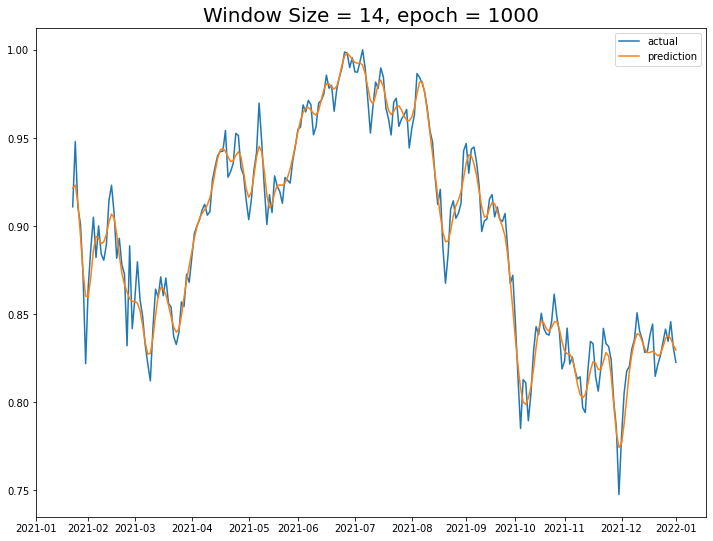

In [24]:
# 저장한 ModelCheckpoint 로드
model.load_weights(filename)
# 예측
pred = model.predict(test_data)
# 성과 지표 출력
print_score(y_test, pred)
# 그래프 출력
plot_result(y_test, pred)

In [25]:
temp = pd.DataFrame(y_test[WINDOW_SIZE:], columns=['actual'])
temp['pred'] = pred
temp['actual_ud'] = temp['actual'].diff().apply(lambda x : 1 if x > 0 else 0)
temp['pred_ud'] = temp['pred'].diff().apply(lambda x : 1 if x > 0 else 0)
temp.head()

,actual,pred,actual_ud,pred_ud
0,0.910921,0.921579,0,0
1,0.947921,0.923205,1,1
2,0.910748,0.913404,0,0
3,0.901140,0.894646,0,0
4,0.872178,0.874143,0,0


In [26]:
print(confusion_matrix(temp['actual_ud'], temp['pred_ud']))
print(f"accuracy : {accuracy_score(temp['actual_ud'], temp['pred_ud']):.3f}")

[[86 29]
 [34 85]]
accuracy : 0.731
